In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 14a

## Sequential Model using ionosphere putting it together

1. Monitor validation set as well as training set
2. L2 Regularization
3. Dropouts
4. Batch Norm
5. Early stopping

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

%matplotlib inline

2024-07-22 17:08:58.541235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 17:08:58.553818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 17:08:58.557522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 17:08:58.567677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 17:08:59.318129: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100         # number of epochs
ALPHA = 0.001        # learning rate
WEIGHT_DECAY = 0.001 # Weight decay
BATCH_SIZE = 16      # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*18)

PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1721648339.849084   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721648339.885098   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721648339.889291   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [6]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [7]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()

y = data_df[data_df.columns[-1]].to_numpy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                   train_size = TRAIN_SIZE,
                                                   stratify=y,
                                                   random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [9]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [10]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [11]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [12]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model1 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (2),
    
])

I0000 00:00:1721648339.971807   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721648339.976164   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721648339.980166   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721648340.127923   37477 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
model1.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])



In [14]:
histroy = model1.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

Epoch 1/100


I0000 00:00:1721648340.762959   37557 service.cc:146] XLA service 0x7163b4005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721648340.762992   37557 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-22 17:09:00.780594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-22 17:09:00.878397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1721648341.822825   37557 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 3s - 144ms/step - accuracy: 0.6771 - loss: 0.6850 - val_accuracy: 0.8095 - val_loss: 0.6441
Epoch 2/100
18/18 - 0s - 3ms/step - accuracy: 0.7847 - loss: 0.6053 - val_accuracy: 0.8254 - val_loss: 0.5847
Epoch 3/100
18/18 - 0s - 3ms/step - accuracy: 0.8472 - loss: 0.5434 - val_accuracy: 0.8413 - val_loss: 0.5315
Epoch 4/100
18/18 - 0s - 3ms/step - accuracy: 0.8854 - loss: 0.4844 - val_accuracy: 0.8413 - val_loss: 0.4745
Epoch 5/100
18/18 - 0s - 3ms/step - accuracy: 0.8924 - loss: 0.4187 - val_accuracy: 0.8571 - val_loss: 0.4202
Epoch 6/100
18/18 - 0s - 3ms/step - accuracy: 0.8958 - loss: 0.3591 - val_accuracy: 0.8571 - val_loss: 0.3795
Epoch 7/100
18/18 - 0s - 3ms/step - accuracy: 0.9097 - loss: 0.3115 - val_accuracy: 0.8571 - val_loss: 0.3483
Epoch 8/100
18/18 - 0s - 3ms/step - accuracy: 0.9167 - loss: 0.2746 - val_accuracy: 0.8571 - val_loss: 0.3247
Epoch 9/100
18/18 - 0s - 3ms/step - accuracy: 0.9201 - loss: 0.2455 - val_accuracy: 0.8571 - val_loss: 0.3065
Epoch 10/100
18/18 -

In [15]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 26)             │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,826 (18.86 KB)

 Trainable params: 1,608 (6.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,218 (12.57 KB)

In [16]:
hist_df = pd.DataFrame(histroy.history)
hist_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.677083,0.685037,0.809524,0.644071
1,0.784722,0.605274,0.825397,0.584706
2,0.847222,0.543363,0.841270,0.531548
3,0.885417,0.484404,0.841270,0.474519
4,0.892361,0.418746,0.857143,0.420189


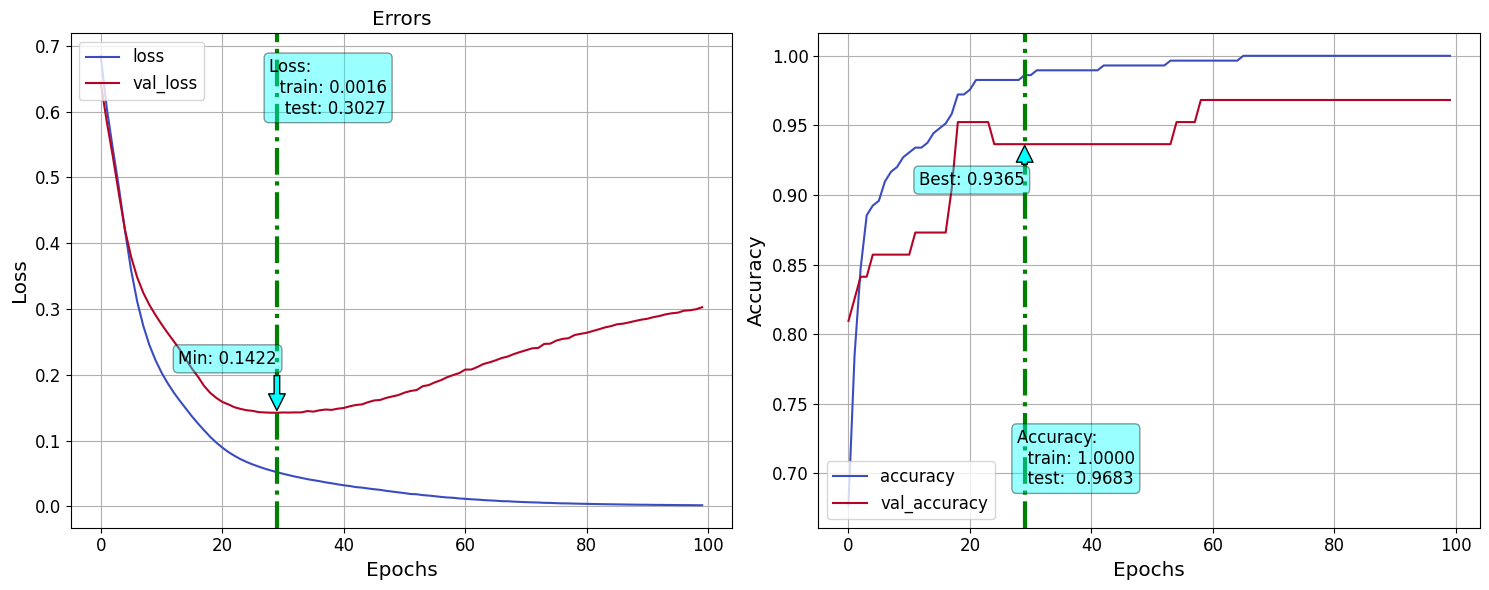

In [17]:
fn_plot_tf_hist(hist_df)

In [18]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
29,0.986111,0.051975,0.936508,0.142243


In [19]:
proba_model1 = tf.keras.Sequential([model1,
                                   tf.keras.layers.Softmax()])

y_pred = proba_model1(X_test)

In [20]:
class_name

['b', 'g']

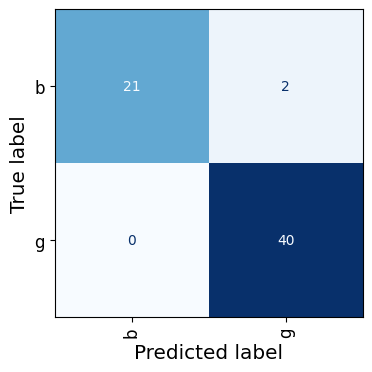

In [21]:
fn_plot_confusion_matrix(y_test, y_pred.numpy().argmax(axis = 1), labels=class_name)

## L2 Regularizer

In [22]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

regularizer = tf.keras.regularizers.L2(0.05)

model2 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( shape =( 34, ) ),

    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (2),
    
])

model2.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model2.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 3s - 149ms/step - accuracy: 0.3993 - loss: 3.6768 - val_accuracy: 0.4444 - val_loss: 3.4216
Epoch 2/100
18/18 - 0s - 3ms/step - accuracy: 0.6562 - loss: 3.2356 - val_accuracy: 0.8095 - val_loss: 3.0390
Epoch 3/100
18/18 - 0s - 3ms/step - accuracy: 0.8438 - loss: 2.8917 - val_accuracy: 0.8571 - val_loss: 2.7272
Epoch 4/100
18/18 - 0s - 3ms/step - accuracy: 0.8750 - loss: 2.5954 - val_accuracy: 0.8730 - val_loss: 2.4516
Epoch 5/100
18/18 - 0s - 3ms/step - accuracy: 0.8924 - loss: 2.3299 - val_accuracy: 0.9048 - val_loss: 2.2067
Epoch 6/100
18/18 - 0s - 3ms/step - accuracy: 0.9028 - loss: 2.0924 - val_accuracy: 0.9206 - val_loss: 1.9885
Epoch 7/100
18/18 - 0s - 3ms/step - accuracy: 0.9201 - loss: 1.8797 - val_accuracy: 0.9206 - val_loss: 1.7954
Epoch 8/100
18/18 - 0s - 3ms/step - accuracy: 0.9236 - loss: 1.6900 - val_accuracy: 0.9048 - val_loss: 1.6245
Epoch 9/100
18/18 - 0s - 3ms/step - accuracy: 0.9236 - loss: 1.5230 - val_accuracy: 0.9048 - val_loss: 1.4739
Epoch 10

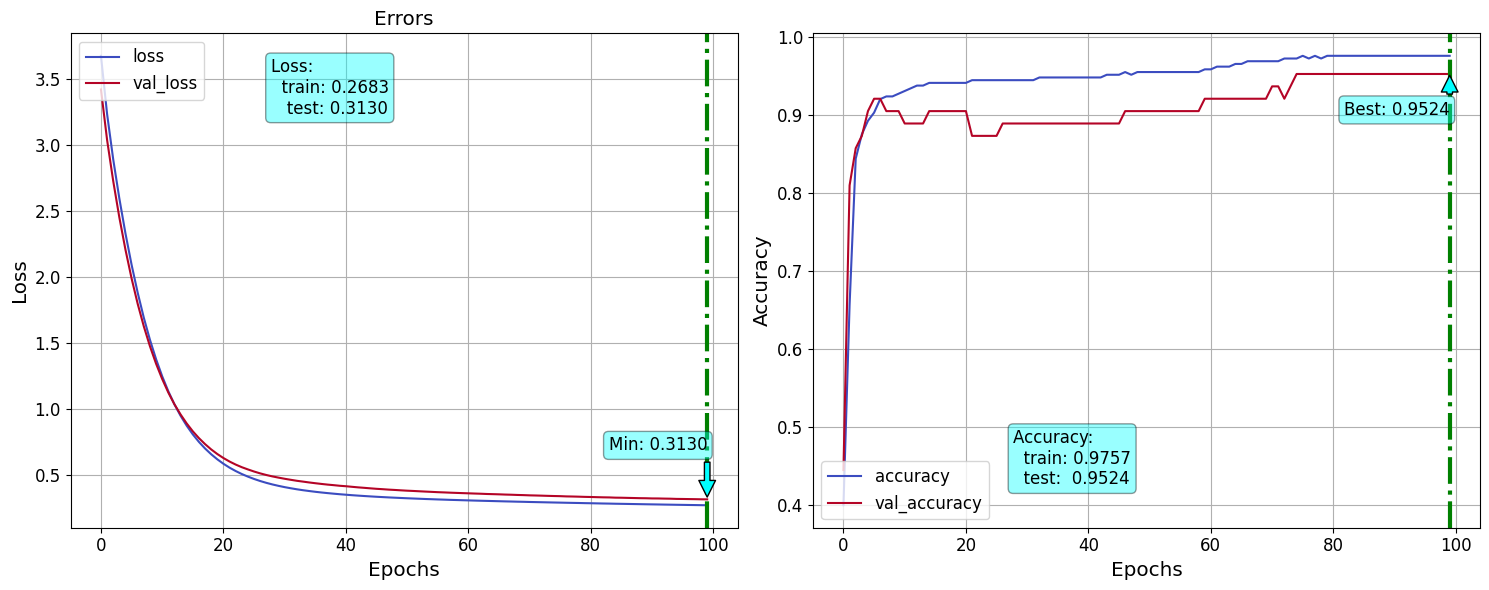

In [23]:
fn_plot_tf_hist(hist_df)

## Batch Normalization

In [24]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model3 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (2),
    
])


model3.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model3.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 3s - 174ms/step - accuracy: 0.4514 - loss: 0.7654 - val_accuracy: 0.4286 - val_loss: 0.6759
Epoch 2/100
18/18 - 0s - 3ms/step - accuracy: 0.6771 - loss: 0.6114 - val_accuracy: 0.6349 - val_loss: 0.6235
Epoch 3/100
18/18 - 0s - 3ms/step - accuracy: 0.8125 - loss: 0.5206 - val_accuracy: 0.7937 - val_loss: 0.5729
Epoch 4/100
18/18 - 0s - 3ms/step - accuracy: 0.8507 - loss: 0.4551 - val_accuracy: 0.8413 - val_loss: 0.5320
Epoch 5/100
18/18 - 0s - 3ms/step - accuracy: 0.8854 - loss: 0.4014 - val_accuracy: 0.8730 - val_loss: 0.4907
Epoch 6/100
18/18 - 0s - 3ms/step - accuracy: 0.9028 - loss: 0.3567 - val_accuracy: 0.8730 - val_loss: 0.4504
Epoch 7/100
18/18 - 0s - 3ms/step - accuracy: 0.9201 - loss: 0.3203 - val_accuracy: 0.8730 - val_loss: 0.4119
Epoch 8/100
18/18 - 0s - 3ms/step - accuracy: 0.9271 - loss: 0.2898 - val_accuracy: 0.9206 - val_loss: 0.3767
Epoch 9/100
18/18 - 0s - 3ms/step - accuracy: 0.9340 - loss: 0.2648 - val_accuracy: 0.9206 - val_loss: 0.3436
Epoch 10

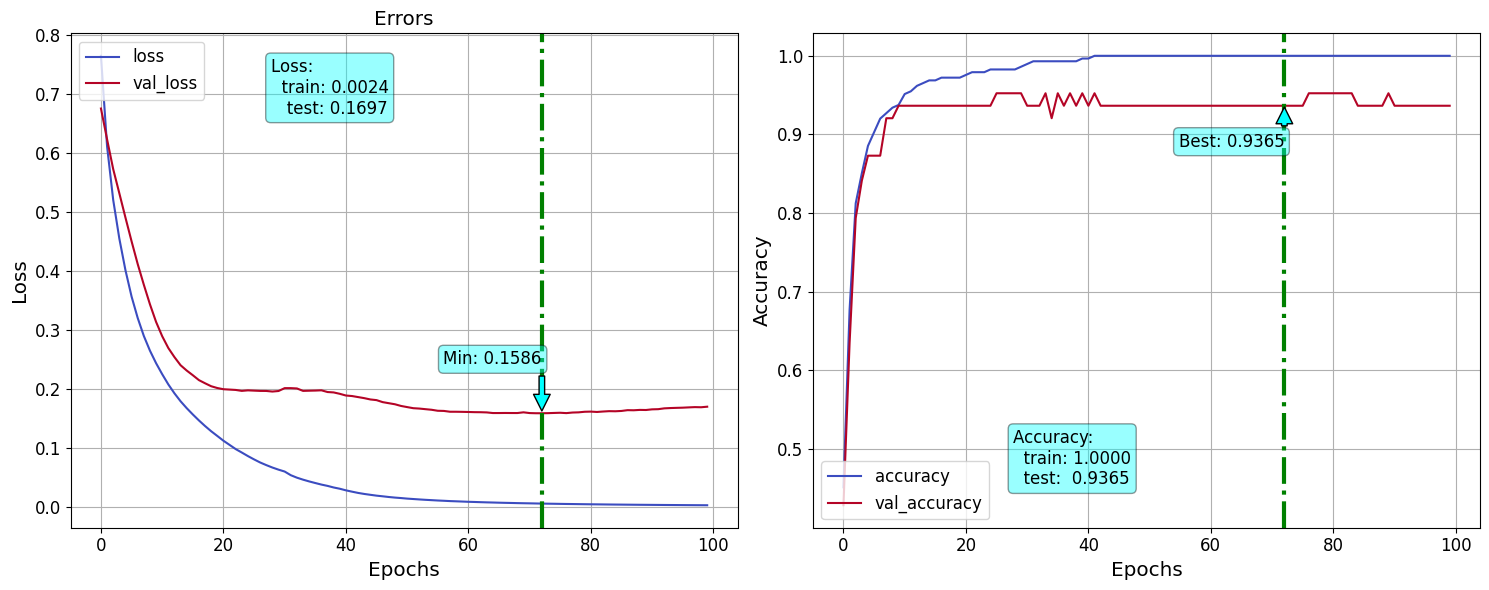

In [25]:
fn_plot_tf_hist(hist_df)

In [26]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
72,1.0,0.005257,0.936508,0.158619


## DROP OUTS

In [27]:
rate1 = 0.2
rate2 = 0.3
rate3 = 0.4

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model4 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


model4.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model4.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 3s - 158ms/step - accuracy: 0.3924 - loss: 0.8771 - val_accuracy: 0.3651 - val_loss: 0.7250
Epoch 2/100
18/18 - 0s - 3ms/step - accuracy: 0.4896 - loss: 0.7214 - val_accuracy: 0.6032 - val_loss: 0.6586
Epoch 3/100
18/18 - 0s - 3ms/step - accuracy: 0.5278 - loss: 0.6951 - val_accuracy: 0.7937 - val_loss: 0.6206
Epoch 4/100
18/18 - 0s - 3ms/step - accuracy: 0.6250 - loss: 0.6632 - val_accuracy: 0.8413 - val_loss: 0.5963
Epoch 5/100
18/18 - 0s - 3ms/step - accuracy: 0.7014 - loss: 0.6145 - val_accuracy: 0.8571 - val_loss: 0.5762
Epoch 6/100
18/18 - 0s - 3ms/step - accuracy: 0.7500 - loss: 0.6007 - val_accuracy: 0.8730 - val_loss: 0.5540
Epoch 7/100
18/18 - 0s - 3ms/step - accuracy: 0.7847 - loss: 0.5671 - val_accuracy: 0.9048 - val_loss: 0.5286
Epoch 8/100
18/18 - 0s - 3ms/step - accuracy: 0.7951 - loss: 0.5471 - val_accuracy: 0.9048 - val_loss: 0.4998
Epoch 9/100
18/18 - 0s - 3ms/step - accuracy: 0.8368 - loss: 0.5265 - val_accuracy: 0.9048 - val_loss: 0.4689
Epoch 10

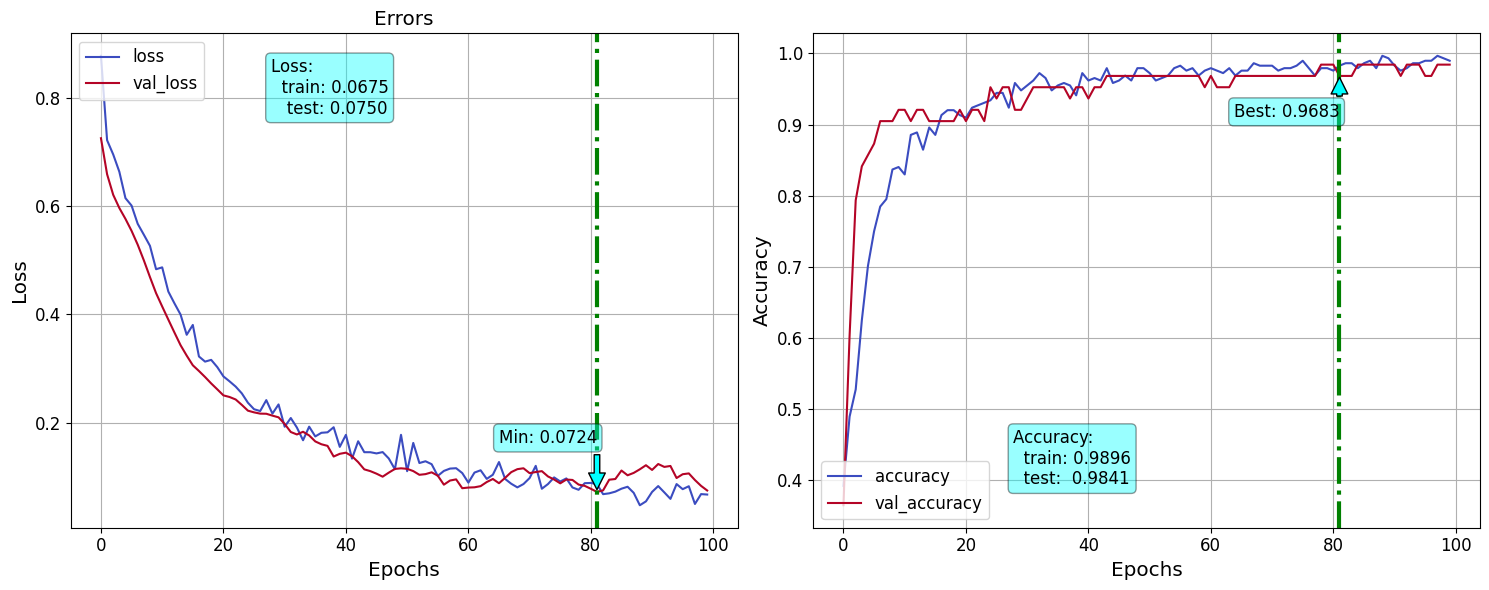

In [28]:
fn_plot_tf_hist(hist_df)

In [29]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
81,0.982639,0.08679,0.968254,0.072361


### All In

In [30]:
rate1 = 0.05
rate2 = 0.15
rate3 = 0.25

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA, weight_decay=WEIGHT_DECAY) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

# Suppressing regularization
#regularizer = tf.keras.regularizers.L2(0.05)
regularizer = None

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])

model.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])

In [31]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'all_in.keras')

# Model is saved at the end of every epoch, if it's the best seen so far.
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose = 2,
    save_best_only=True
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose = 2,
    baseline =None,
    restore_best_weights=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001)

In [32]:
history = model.fit( x = X_train, 
                     y = y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2,
                    callbacks = [es_callback, chkpt_callback, lr_callback])

hist_df = pd.DataFrame(history.history)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.89870, saving model to ../models/ionosphere/all_in.keras
18/18 - 3s - 191ms/step - accuracy: 0.4618 - loss: 1.1090 - val_accuracy: 0.4444 - val_loss: 0.8987 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss improved from 0.89870 to 0.73902, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 4ms/step - accuracy: 0.5799 - loss: 0.8811 - val_accuracy: 0.5556 - val_loss: 0.7390 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_loss improved from 0.73902 to 0.62764, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 4ms/step - accuracy: 0.6424 - loss: 0.6924 - val_accuracy: 0.8413 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss improved from 0.62764 to 0.56326, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 4ms/step - accuracy: 0.6806 - loss: 0.6412 - val_accuracy: 0.8730 - val_loss: 0.5633 - learning_rate: 0.0010
Epoch 5/100

Epoch 5: val_loss improved from 0.56326 t

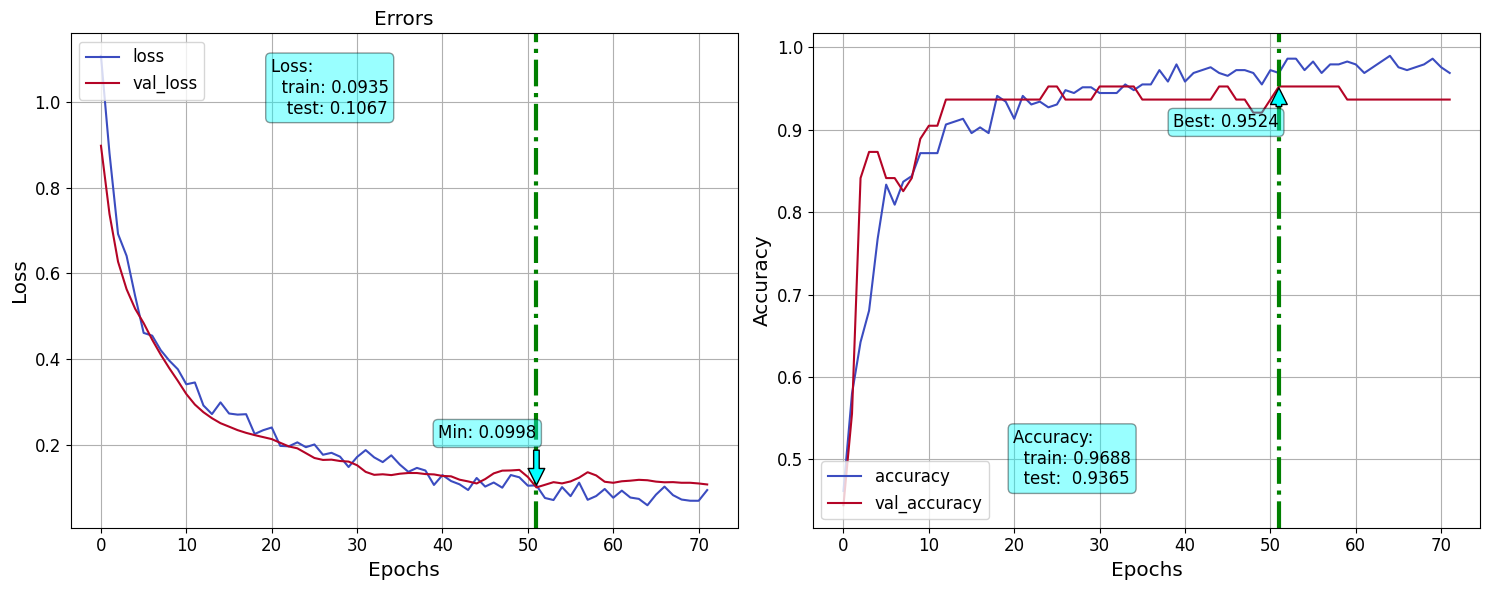

In [33]:
fn_plot_tf_hist(hist_df)

In [34]:
loss_dict = model.evaluate(X_test, y_test, verbose=1 , return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.9474 - loss: 0.1004


In [35]:
loss_dict

{'accuracy': 0.9523809552192688, 'loss': 0.09977906942367554}

In [36]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss,learning_rate
51,0.96875,0.104433,0.952381,0.099779,0.001


In [37]:
del model
del model1
del model2
del model3
del model4

## Save Complete Model

In [38]:
# Load the best model
model = tf.keras.models.load_model(checkpoint_filepath)

In [39]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 26)             │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26)             │           104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 18)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18)             │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,258 (20.54 KB)

 Trainable params: 1,716 (6.70 KB)

 Non-trainable params: 108 (432.00 B)

 Optimizer params: 3,434 (13.42 KB)

In [40]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 1s - 586ms/step - accuracy: 0.9524 - loss: 0.0998


0.9523809552192688